# Importing modules and loading the data


In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from scipy.stats import mode
import urllib
from PIL import Image
from colour import Color



%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Downloading data
If you haven't alraedy, please download the data (200 Mb) from:
https://drive.google.com/file/d/0BzyCB-i-aKDWU2pBYkVoOV81S3M/view?usp=sharing
and name it "pairwise_causality_regional_CSD.csv". This procedure is absolutely neccesary for anything in this notebook to run. If you can not download the data, please contact me directly at "kamal@kamalaldin.com"

In [3]:
data = pd.read_csv("pairwise_causality_regional_CSD.csv")
print("Reading data successful!")

Reading data successful!


# Cleaning the data
As we know from before, the data is composed of 7 columns as follows:
1. Strange naming convention from R
2. The number of the node from which the causality is coming
3. The number of the node to which causality is coming
4. The causality strength
5. Start time of the time window
6. The length of the time window
7. The time steps between time windows

We don't need the first column anymore, so we remove it. And because we want to analyze different time steps and time windows differently, we will split those into separate datasets. So our actions to clean the data are:
* remove pointless first column
* remove any data anomalies that might be there.
* separate the dataset into three different datasets depending on the time window and time step.
* remove any columns that might not be needed

#### Removing first column

In [4]:
#show the dimensions and columns of the data
print("The shape of the data is {}".format(data.shape))
display(data.head())

The shape of the data is (1950300, 7)


,Unnamed: 0,to,from,rho,start.time,time.window,time.step
0,structure.c.2..3..1..0..2000....Names...c..to....,1,2,1.000000,0.0,2000,250
1,structure.c.2..4..0.859542235813667..0..2000.....,1,3,0.859542,0.0,2000,250
2,structure.c.2..5..0.211063556137699..0..2000.....,1,4,0.211064,0.0,2000,250
3,structure.c.2..6..0.771943439892916..0..2000.....,1,5,0.771943,0.0,2000,250
4,structure.c.2..7..0.63844791539324..0..2000......,1,6,0.638448,0.0,2000,250


In [5]:
#remove unneeded first column
data = data.drop("Unnamed: 0", axis=1) #drop the first column
display(data.head())
display(data.describe())

,to,from,rho,start.time,time.window,time.step
0,1,2,1.000000,0.0,2000,250
1,1,3,0.859542,0.0,2000,250
2,1,4,0.211064,0.0,2000,250
3,1,5,0.771943,0.0,2000,250
4,1,6,0.638448,0.0,2000,250


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,to,from,rho,start.time,time.window,time.step
count,1.950300e+06,1.950300e+06,1.950293e+06,1.950300e+06,1.950300e+06,1.950300e+06
mean,6.500000e+00,6.500000e+00,6.154629e-01,2.546897e+05,4.482843e+02,1.034450e+02
std,3.452053e+00,3.452053e+00,3.427891e-01,1.470750e+05,6.206986e+02,8.086868e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+02,5.000000e+01
25%,3.750000e+00,3.750000e+00,NaN,1.273000e+05,2.000000e+02,5.000000e+01
50%,6.500000e+00,6.500000e+00,NaN,2.547000e+05,2.000000e+02,5.000000e+01
75%,9.250000e+00,9.250000e+00,NaN,3.820500e+05,2.000000e+02,2.000000e+02
max,1.200000e+01,1.200000e+01,1.000000e+00,5.094500e+05,2.000000e+03,2.500000e+02


#### Replacing erronous data (NaN)
From the summary above, we see that there are some NaNs in the rho column. We will have to replace those with 0. We can not completely remove these datapoints because our methods rely heavily on continuous data points, so having the same time steps is imporatnt, so we simply assume that the causality is 0 rather than delete the datapoint.

In [6]:
#removing Nan's in rho
print("data points where rho is nan:")
print(data[np.isnan(data['rho'])])
data.loc[np.isnan(data.rho), 'rho'] = 0
print("\n seeing if example index 1950114 has been changed correctly:")
print(data.iloc[1950114])

data points where rho is nan:
         to  from  rho  start.time  time.window  time.step
1950114   4     2  NaN    509400.0          200         50
1950116   6     2  NaN    509400.0          200         50
1950117   7     2  NaN    509400.0          200         50
1950118   8     2  NaN    509400.0          200         50
1950119   9     2  NaN    509400.0          200         50
1950121  11     2  NaN    509400.0          200         50
1950122  12     2  NaN    509400.0          200         50

 seeing if example index 1950114 has been changed correctly:
to                  4.0
from                2.0
rho                 0.0
start.time     509400.0
time.window       200.0
time.step          50.0
Name: 1950114, dtype: float64


#### Separating datasets based on timesteps
It seems that we fixed the NaN issue in some rho values! We know from our experiment that we have 3 time step values that correspond to a different timerange with which the experiment was done, so we separate the data depending on their timesteps.

In [7]:
time_steps = data['time.step'].unique()
print("There are {} time steps in the dataset:{}".format(len(time_steps), time_steps))
time_windows = data['time.window'].unique()
print("There are {} time windows in the dataset:{}".format(len(time_windows), time_windows))
data_ts_50 = data[data['time.step'] == 50].reset_index(drop=True)
data_ts_200 = data[data['time.step']== 200].reset_index(drop=True)
data_ts_250 = data[data['time.step']== 250].reset_index(drop=True)

display(data_ts_50.head(3))
display(data_ts_200.head(3))
display(data_ts_250.head(3))

print("Shape of data of timestep of 50:", data_ts_50.shape)
print("Shape of data of timestep of 200:", data_ts_200.shape)
print("Shape of data of timestep of 250:", data_ts_250.shape)

There are 3 time steps in the dataset:[250 200  50]
There are 2 time windows in the dataset:[2000  200]


,to,from,rho,start.time,time.window,time.step
0,1,2,0.000000,0.0,200,50
1,1,3,0.497399,0.0,200,50
2,1,4,0.239877,0.0,200,50


,to,from,rho,start.time,time.window,time.step
0,1,2,0.000000,0.0,200,200
1,1,3,0.475417,0.0,200,200
2,1,4,0.232281,0.0,200,200


,to,from,rho,start.time,time.window,time.step
0,1,2,1.000000,0.0,2000,250
1,1,3,0.859542,0.0,2000,250
2,1,4,0.211064,0.0,2000,250


Shape of data of timestep of 50: (1345080, 6)
Shape of data of timestep of 200: (336204, 6)
Shape of data of timestep of 250: (269016, 6)


#### Removing unnecessary columns after the dataset split
Each of these datasets have a unique time window as can be seen from below.

In [8]:
print(data_ts_50['time.window'].unique())
print(data_ts_200['time.window'].unique())
print(data_ts_250['time.window'].unique())

[200]
[200]
[2000]


Since we know there are unique times windows in the datasets, we can get rid of that column. We can also get rid of the time.step column since it's redundant now that we have split up the data into three datasets.

In [9]:
data_ts_50 = data_ts_50.drop(['time.window', 'time.step'], axis=1)
data_ts_200 = data_ts_200.drop(['time.window', 'time.step'], axis=1)
data_ts_250 = data_ts_250.drop(['time.window', 'time.step'], axis=1)


display(data_ts_50.head(3))
display(data_ts_200.head(3))
display(data_ts_250.head(3))

,to,from,rho,start.time
0,1,2,0.000000,0.0
1,1,3,0.497399,0.0
2,1,4,0.239877,0.0


,to,from,rho,start.time
0,1,2,0.000000,0.0
1,1,3,0.475417,0.0
2,1,4,0.232281,0.0


,to,from,rho,start.time
0,1,2,1.000000,0.0
1,1,3,0.859542,0.0
2,1,4,0.211064,0.0


Now we need to sort the three datasets by starting time, from, and to, respectively. Even though the data might come sorted already, we must make sure that's the case.

In [10]:
data_ts_50 = data_ts_50.sort_values(['start.time','from', 'to'])
data_ts_200 = data_ts_200.sort_values(['start.time','from', 'to'])
data_ts_250 = data_ts_250.sort_values(['start.time','from', 'to'])

display(data_ts_50.head(3))
display(data_ts_200.head(3))
display(data_ts_250.head(3))

,to,from,rho,start.time
66,2,1,0.000000,0.0
67,3,1,0.542332,0.0
68,4,1,0.495717,0.0


,to,from,rho,start.time
66,2,1,0.000000,0.0
67,3,1,0.562947,0.0
68,4,1,0.508764,0.0


,to,from,rho,start.time
66,2,1,0.000000,0.0
67,3,1,0.854583,0.0
68,4,1,0.310950,0.0


# Creating datapoints
Now that we have the three datasets separated and sorted properly, we can create a datapoint from each start time. Essentially, this creates a datapoint from each causality graph.

In [11]:
# This takes a while
dataset_ts_50 = {}
for st in sorted(data_ts_50['start.time'].unique()):
    timepoint = data_ts_50[data_ts_50['start.time'] == st]
    timepoint = timepoint.sort_values(['from', 'to'])
    timepoint = tuple(timepoint['rho'])
    dataset_ts_50[st] = timepoint

    
dataset_ts_200 = {}
for st in sorted(data_ts_200['start.time'].unique()):
    timepoint = data_ts_200[data_ts_200['start.time'] == st]
    timepoint = timepoint.sort_values(['from', 'to'])
    timepoint = tuple(timepoint['rho'])
    dataset_ts_200[st] = timepoint
    
dataset_ts_250 = {}
for st in sorted(data_ts_250['start.time'].unique()):
    timepoint = data_ts_250[data_ts_250['start.time'] == st]
    timepoint = timepoint.sort_values(['start.time','from', 'to'])
    timepoint = tuple(timepoint['rho'])
    dataset_ts_250[st] = timepoint

The dictionaries above are simply a middle man for creating the dataframes below. We expect each data frame to contain as many data points as there are 

In [12]:
frame_ts_50 = pd.DataFrame(data=dataset_ts_50).transpose()
frame_ts_200 = pd.DataFrame(data=dataset_ts_200).transpose()
frame_ts_250 = pd.DataFrame(data=dataset_ts_250).transpose()

frame_ts_50.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0.0,0.0,0.542332,0.495717,0.903752,0.643166,0.327822,0.443546,0.499506,0.763753,0.764024,...,0.0,0.777296,0.323094,0.114140,0.184161,0.837615,0.619512,0.406895,0.208400,0.553183
50.0,0.0,0.499673,0.688609,0.762380,0.763109,0.331046,0.647763,0.636914,0.815655,0.712858,...,0.0,0.791199,0.553069,0.234148,0.181529,0.785035,0.630996,0.474935,0.213924,0.549039
100.0,0.0,0.619993,0.889671,0.869894,0.909595,0.628251,0.838746,0.606802,0.893036,0.850969,...,0.0,0.709428,0.534999,0.330050,0.471474,0.644096,0.476649,0.388837,0.474694,0.490920
150.0,0.0,0.831985,0.906330,0.928503,0.868678,0.831844,0.827285,0.763389,0.810151,0.927975,...,0.0,0.919131,0.574910,0.835903,0.534474,0.887378,0.757643,0.792982,0.485954,0.827589
200.0,0.0,0.982548,0.962043,0.968991,0.945124,0.899638,0.809773,0.864984,0.822943,0.954925,...,0.0,0.930587,0.935618,0.915255,0.914564,0.922041,0.807638,0.819265,0.799140,0.900431


# Dimensionality reduction
### Exploration
Now that we have data points for each time window, each of which is 132 dimensional, we can cluster them. But before that, we can see if we can reduce the dimensionality of the data points, since 132 dimensions is quiet a lot of dimensions.

In [13]:
# apply principal component analysis to the data
print("Principal component analysis to dataset with timestep 50")
pca = PCA(n_components=frame_ts_50.shape[1]).fit(frame_ts_50)
explained_variance_timestep_50 = []
for a in range(len(pca.explained_variance_)):
    print("Ratio of explained variance in the first {} components : {}".format(a+1,
            sum(pca.explained_variance_ratio_[:a])))
    explained_variance_timestep_50.append(sum(pca.explained_variance_ratio_[:a]))
    
    
    
print("#"*100)
print("Principal component analysis to dataset with timestep 200")
pca = PCA(n_components=frame_ts_200.shape[1]).fit(frame_ts_200)
explained_variance_timestep_200 = []
for a in range(len(pca.explained_variance_)):
    print("Ratio of explained variance in the first {} components : {}".format(a+1,
            sum(pca.explained_variance_ratio_[:a])))
    explained_variance_timestep_200.append(sum(pca.explained_variance_ratio_[:a]))
    
print("#"*100)
print("Principal component analysis to dataset with timestep 250")
pca = PCA(n_components=frame_ts_250.shape[1]).fit(frame_ts_250)
explained_variance_timestep_250 = []
for a in range(len(pca.explained_variance_)):
    print("Ratio of explained variance in the first {} components : {}".format(a+1,
            sum(pca.explained_variance_ratio_[:a])))
    explained_variance_timestep_250.append(sum(pca.explained_variance_ratio_[:a]))

Principal component analysis to dataset with timestep 50
Ratio of explained variance in the first 1 components : 0
Ratio of explained variance in the first 2 components : 0.4018503096364116
Ratio of explained variance in the first 3 components : 0.45983733149345335
Ratio of explained variance in the first 4 components : 0.5088937229940333
Ratio of explained variance in the first 5 components : 0.5467643411993803
Ratio of explained variance in the first 6 components : 0.57851179932413
Ratio of explained variance in the first 7 components : 0.6071513989698862
Ratio of explained variance in the first 8 components : 0.633050059776303
Ratio of explained variance in the first 9 components : 0.6560793364903866
Ratio of explained variance in the first 10 components : 0.6778963979235246
Ratio of explained variance in the first 11 components : 0.6976727971809052
Ratio of explained variance in the first 12 components : 0.7157315903770113
Ratio of explained variance in the first 13 components : 0.

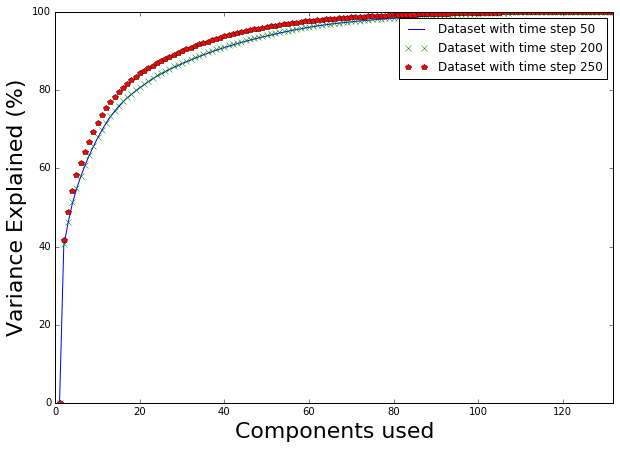

In [14]:
plt.figure(figsize=(10,7))
x = list(range(1,133))
plt.plot(x, np.array(explained_variance_timestep_50)*100, '-', x, np.array(explained_variance_timestep_200)*100,
         'x', x, np.array(explained_variance_timestep_250)*100, 'p')
plt.axis([0,132,0,100])
plt.xlabel("Components used", fontsize=22)
plt.ylabel("Variance Explained (%)", fontsize=22)
plt.legend(loc="upper right", labels=["Dataset with time step 50", "Dataset with time step 200", "Dataset with time step 250"])
plt.savefig("figures/variance_explained_with_pca.pdf")

#### Splitting data
From the result above, we can observe that the following number of components are needed to explain the following percentage of variance.

|  |  80% Variance| 90% Variance | 99% Variance |
|---|---|---|---|---|
| # Components in dataset_50  | 20  | 38  | 87  |
| # Components in dataset_200 |  20 | 37  | 87  |  
| # Components in dataset_250  |  16 |  30 |  76 | 

We try the different PCA reductions and see what they give us in terms of scoring!

In [15]:
# We now try to reduce the dimensionality of the data by transforming them to fewere principal components
reduced_data_50_ts_80 = PCA(n_components=20).fit_transform(frame_ts_50)
reduced_data_50_ts_90 = PCA(n_components=38).fit_transform(frame_ts_50)
reduced_data_50_ts_99 = PCA(n_components=87).fit_transform(frame_ts_50)
pcas_of_50 = [reduced_data_50_ts_80, reduced_data_50_ts_90, reduced_data_50_ts_99]

reduced_data_200_ts_80 = PCA(n_components=20).fit_transform(frame_ts_200)
reduced_data_200_ts_90 = PCA(n_components=37).fit_transform(frame_ts_200)
reduced_data_200_ts_99 = PCA(n_components=87).fit_transform(frame_ts_200)
pcas_of_200 = [reduced_data_200_ts_80, reduced_data_200_ts_90, reduced_data_200_ts_99]


reduced_data_250_ts_80 = PCA(n_components=16).fit_transform(frame_ts_250)
reduced_data_250_ts_90 = PCA(n_components=30).fit_transform(frame_ts_250)
reduced_data_250_ts_99 = PCA(n_components=76).fit_transform(frame_ts_250)
pcas_of_250 = [reduced_data_250_ts_80, reduced_data_250_ts_90, reduced_data_250_ts_99]

Now that we have the datasets in transformed, reduced PCA form, we can perform clustering on them. We see many clustering possiblities, and see which clustering number produces the best results when run them through silhouette and Calinksy clustering tests.

# NOTE: YOU DON'T HAVE TO RUN THESE TESTS, PLEASE SKIP TO 'LOADING FROM FILE' TO AVOID THE LONG COMPUTATION

In [112]:
#THIS TAKES A WHILE
silhouette_scores_50_80 = {}
silhouette_scores_50_90 = {}
silhouette_scores_50_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 50 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_80)
    preds = clusterer.predict(reduced_data_50_ts_80)
    score = silhouette_score(reduced_data_50_ts_80, preds)
    silhouette_scores_50_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_90)
    preds = clusterer.predict(reduced_data_50_ts_90)
    score = silhouette_score(reduced_data_50_ts_90, preds)
    silhouette_scores_50_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_99)
    preds = clusterer.predict(reduced_data_50_ts_99)
    score = silhouette_score(reduced_data_50_ts_99, preds)
    silhouette_scores_50_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [113]:
silhouette_scores_200_80 = {}
silhouette_scores_200_90 = {}
silhouette_scores_200_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_80)
    preds = clusterer.predict(reduced_data_200_ts_80)
    score = silhouette_score(reduced_data_200_ts_80, preds)
    silhouette_scores_200_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_90)
    preds = clusterer.predict(reduced_data_200_ts_90)
    score = silhouette_score(reduced_data_200_ts_90, preds)
    silhouette_scores_200_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_99)
    preds = clusterer.predict(reduced_data_200_ts_99)
    score = silhouette_score(reduced_data_200_ts_99, preds)
    silhouette_scores_200_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4
done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [114]:
silhouette_scores_250_80 = {}
silhouette_scores_250_90 = {}
silhouette_scores_250_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_80)
    preds = clusterer.predict(reduced_data_250_ts_80)
    score = silhouette_score(reduced_data_250_ts_80, preds)
    silhouette_scores_250_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_90)
    preds = clusterer.predict(reduced_data_250_ts_90)
    score = silhouette_score(reduced_data_250_ts_90, preds)
    silhouette_scores_250_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_99)
    preds = clusterer.predict(reduced_data_250_ts_99)
    score = silhouette_score(reduced_data_250_ts_99, preds)
    silhouette_scores_250_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4
done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [183]:
#THIS TAKES A WHILE
calinsky_scores_50_80 = {}
calinsky_scores_50_90 = {}
calinsky_scores_50_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 50 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_80)
    preds = clusterer.predict(reduced_data_50_ts_80)
    score = calinski_harabaz_score(reduced_data_50_ts_80, preds)
    calinsky_scores_50_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_90)
    preds = clusterer.predict(reduced_data_50_ts_90)
    score = calinski_harabaz_score(reduced_data_50_ts_90, preds)
    calinsky_scores_50_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_50_ts_99)
    preds = clusterer.predict(reduced_data_50_ts_99)
    score = calinski_harabaz_score(reduced_data_50_ts_99, preds)
    calinsky_scores_50_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [184]:
calinsky_scores_200_80 = {}
calinsky_scores_200_90 = {}
calinsky_scores_200_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_80)
    preds = clusterer.predict(reduced_data_200_ts_80)
    score = calinski_harabaz_score(reduced_data_200_ts_80, preds)
    calinsky_scores_200_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_90)
    preds = clusterer.predict(reduced_data_200_ts_90)
    score = calinski_harabaz_score(reduced_data_200_ts_90, preds)
    calinsky_scores_200_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_200_ts_99)
    preds = clusterer.predict(reduced_data_200_ts_99)
    score = calinski_harabaz_score(reduced_data_200_ts_99, preds)
    calinsky_scores_200_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4
done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [185]:
calinsky_scores_250_80 = {}
calinsky_scores_250_90 = {}
calinsky_scores_250_99 = {}
for n_components in range(2, 41):
    #predict cluster labels and measure score for 80% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_80)
    preds = clusterer.predict(reduced_data_250_ts_80)
    score = calinski_harabaz_score(reduced_data_250_ts_80, preds)
    calinsky_scores_250_80[n_components] = score
    
    #predict cluster labels and measure score for 90% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_90)
    preds = clusterer.predict(reduced_data_250_ts_90)
    score = calinski_harabaz_score(reduced_data_250_ts_90, preds)
    calinsky_scores_250_90[n_components] = score
    
    #predict cluster labels and measure score for 99% variance explained on 250 dataset
    clusterer = GaussianMixture(n_components=n_components, random_state=42).fit(reduced_data_250_ts_99)
    preds = clusterer.predict(reduced_data_250_ts_99)
    score = calinski_harabaz_score(reduced_data_250_ts_99, preds)
    calinsky_scores_250_99[n_components] = score
    print("done with components", n_components)

done with components 2
done with components 3
done with components 4
done with components 5
done with components 6
done with components 7
done with components 8
done with components 9
done with components 10
done with components 11
done with components 12
done with components 13
done with components 14
done with components 15
done with components 16
done with components 17
done with components 18
done with components 19
done with components 20
done with components 21
done with components 22
done with components 23
done with components 24
done with components 25
done with components 26
done with components 27
done with components 28
done with components 29
done with components 30
done with components 31
done with components 32
done with components 33
done with components 34
done with components 35
done with components 36
done with components 37
done with components 38
done with components 39
done with components 40


In [116]:
# save the silhouette scores to a file to examine them without recalculation later on
with open('silhouette_scores_50_80.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_50_80, file)
with open('silhouette_scores_50_90.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_50_90, file)
with open('silhouette_scores_50_99.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_50_99, file)
    
    
with open('silhouette_scores_200_80.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_200_80, file)
with open('silhouette_scores_200_90.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_200_90, file)
with open('silhouette_scores_200_99.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_200_99, file)
    
    
with open('silhouette_scores_250_80.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_250_80, file)
with open('silhouette_scores_250_90.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_250_90, file)
with open('silhouette_scores_250_99.pickle', 'wb') as file:
    pickle.dump(silhouette_scores_250_99, file)

In [187]:
# save the calinksi scores to a file to examine them without recalculation later on

with open('calinsky_scores_50_80.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_50_80, file)
with open('calinsky_scores_50_90.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_50_90, file)
with open('calinsky_scores_50_99.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_50_99, file)
    
    
with open('calinsky_scores_200_80.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_200_80, file)
with open('calinsky_scores_200_90.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_200_90, file)
with open('calinsky_scores_200_99.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_200_99, file)
    
    
with open('calinsky_scores_250_80.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_250_80, file)
with open('calinsky_scores_250_90.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_250_90, file)
with open('calinsky_scores_250_99.pickle', 'wb') as file:
    pickle.dump(calinsky_scores_250_99, file)

# Loading from file
The silhouette and calinsky scores have been pre-computed and stored on file for the reader to load without the extensive computation it requires. Please run the steps below to load the scores for each dataset

In [16]:
# To load the silhouette scores from disk.

with open('silhouette_scores_50_80.pickle', 'rb') as file:
    silhouette_scores_50_80 = pickle.load(file)
with open('silhouette_scores_50_90.pickle', 'rb') as file:
    silhouette_scores_50_90 = pickle.load(file)
with open('silhouette_scores_50_99.pickle', 'rb') as file:
    silhouette_scores_50_99 = pickle.load(file)
    
    
with open('silhouette_scores_200_80.pickle', 'rb') as file:
    silhouette_scores_200_80 = pickle.load(file)
with open('silhouette_scores_200_90.pickle', 'rb') as file:
    silhouette_scores_200_90 = pickle.load(file)
with open('silhouette_scores_200_99.pickle', 'rb') as file:
    silhouette_scores_200_99 = pickle.load(file)
    
    
with open('silhouette_scores_250_80.pickle', 'rb') as file:
    silhouette_scores_250_80 = pickle.load(file)
with open('silhouette_scores_250_90.pickle', 'rb') as file:
    silhouette_scores_250_90 = pickle.load(file)
with open('silhouette_scores_250_99.pickle', 'rb') as file:
    silhouette_scores_250_99 = pickle.load(file)

In [17]:
# To load the calinsky scores from disk.

with open('calinsky_scores_50_80.pickle', 'rb') as file:
    calinsky_scores_50_80 = pickle.load(file)
with open('calinsky_scores_50_90.pickle', 'rb') as file:
    calinsky_scores_50_90 = pickle.load(file)
with open('calinsky_scores_50_99.pickle', 'rb') as file:
    calinsky_scores_50_99 = pickle.load(file)
    
    
with open('calinsky_scores_200_80.pickle', 'rb') as file:
    calinsky_scores_200_80 = pickle.load(file)
with open('calinsky_scores_200_90.pickle', 'rb') as file:
    calinsky_scores_200_90 = pickle.load(file)
with open('calinsky_scores_200_99.pickle', 'rb') as file:
    calinsky_scores_200_99 = pickle.load(file)
    
    
with open('calinsky_scores_250_80.pickle', 'rb') as file:
    calinsky_scores_250_80 = pickle.load(file)
with open('calinsky_scores_250_90.pickle', 'rb') as file:
    calinsky_scores_250_90 = pickle.load(file)
with open('calinsky_scores_250_99.pickle', 'rb') as file:
    calinsky_scores_250_99 = pickle.load(file)

Now that we have the scores, we will plot them to see if we can notice any trends. 

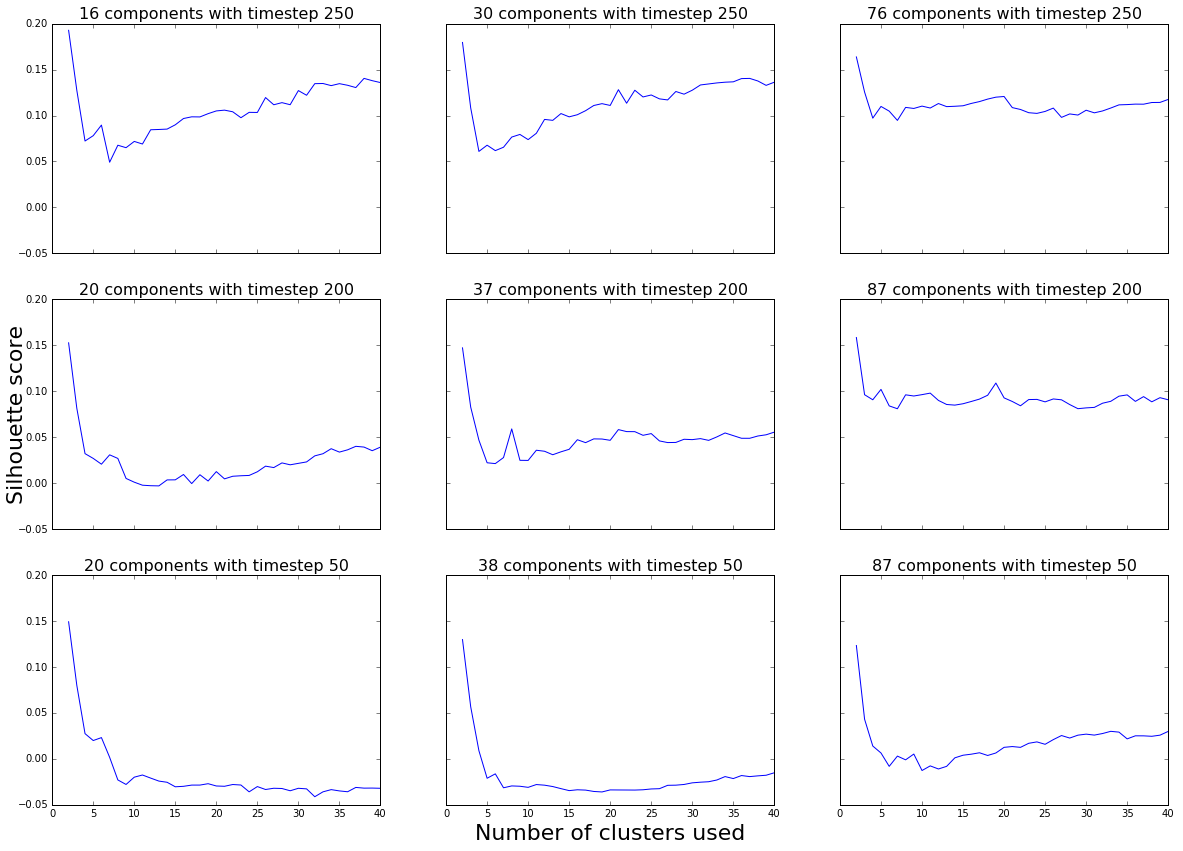

In [18]:
#Plot the silhouette scores.
def plot_x_y_from_dictionary(dictionary, subplot_handle, xlabel):    
    x = []
    y = []
    for key, val in dictionary.items():
        x.append(key)
        y.append(val)
    subplot_handle.plot(x,y)
    subplot_handle.set_title(xlabel, fontsize=16)

fig, ((a1,a2,a3), (b1,b2,b3), (c1,c2,c3)) = plt.subplots(3, 3, figsize=(20,14), sharex=True, sharey=True)
plot_x_y_from_dictionary(silhouette_scores_250_80, a1, "16 components with timestep 250")
plot_x_y_from_dictionary(silhouette_scores_250_90, a2, "30 components with timestep 250")
plot_x_y_from_dictionary(silhouette_scores_250_99, a3, "76 components with timestep 250")
plot_x_y_from_dictionary(silhouette_scores_200_80, b1, "20 components with timestep 200")
plot_x_y_from_dictionary(silhouette_scores_200_90, b2, "37 components with timestep 200")
plot_x_y_from_dictionary(silhouette_scores_200_99, b3, "87 components with timestep 200")
plot_x_y_from_dictionary(silhouette_scores_50_80, c1, "20 components with timestep 50")
plot_x_y_from_dictionary(silhouette_scores_50_90, c2, "38 components with timestep 50")
plot_x_y_from_dictionary(silhouette_scores_50_99, c3, "87 components with timestep 50")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel("Silhouette score", fontsize=22)
plt.xlabel("Number of clusters used", fontsize=22)
fig.savefig("figures/silhouette_scores.pdf")

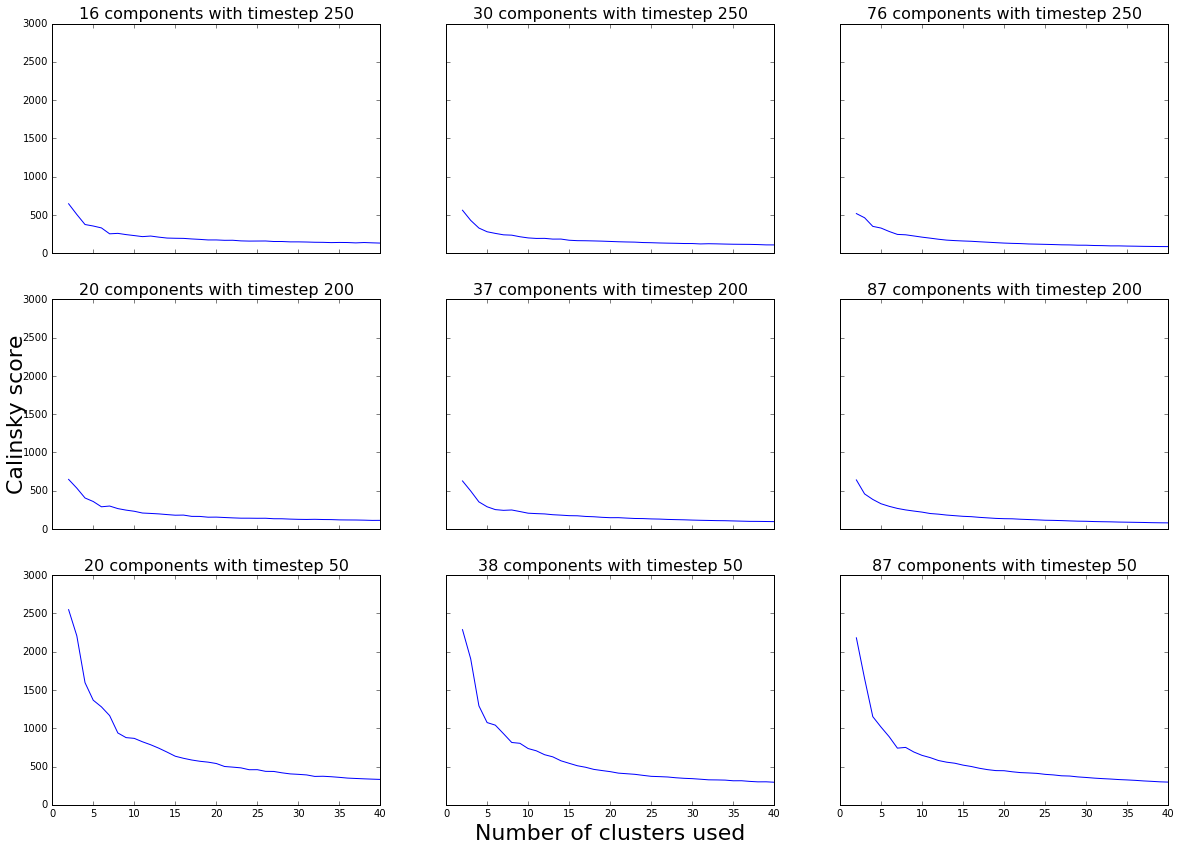

In [19]:
# plot the calinsky scores
fig, ((a1,a2,a3), (b1,b2,b3), (c1,c2,c3)) = plt.subplots(3, 3, figsize=(20,14), sharex=True, sharey=True)
plot_x_y_from_dictionary(calinsky_scores_250_80, a1, "16 components with timestep 250")
plot_x_y_from_dictionary(calinsky_scores_250_90, a2, "30 components with timestep 250")
plot_x_y_from_dictionary(calinsky_scores_250_99, a3, "76 components with timestep 250")
plot_x_y_from_dictionary(calinsky_scores_200_80, b1, "20 components with timestep 200")
plot_x_y_from_dictionary(calinsky_scores_200_90, b2, "37 components with timestep 200")
plot_x_y_from_dictionary(calinsky_scores_200_99, b3, "87 components with timestep 200")
plot_x_y_from_dictionary(calinsky_scores_50_80, c1, "20 components with timestep 50")
plot_x_y_from_dictionary(calinsky_scores_50_90, c2, "38 components with timestep 50")
plot_x_y_from_dictionary(calinsky_scores_50_99, c3, "87 components with timestep 50")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel("Calinsky score", fontsize=22)
plt.xlabel("Number of clusters used", fontsize=22)
fig.savefig("figures/calinsky_scores.pdf")

# Model Evaluation
#### F1
The results so far indicate that the rat's brain showed the presence of two distinct brain states, as we can cluster the brain's communication network into two clusters. This could be good news, since we can assume that the two brain states are epilepsy state and normal state. This simplifies our choice of metric to evaluate the model since we can use a simple F1 measurement by assuming the less frequent brain state is the epileptic state, and record the less occurring cluster as the epileptic cluster; we then test the time indecies of this cluster with the time indecies we were given for when epilepsy was evoked. Since we know that the epilepsy happened between seconds 447-457 and 250-260, we set true labels to be 0 for all data points that were in that time period, and 1 for all other data points. We then set the less frequent cluster to be of label 0 (epilepsy cluster) and the more frequent cluster to 1 (non-epilepsy cluster). Our evaluation metric then becomes the F1 score of the predicted labels against the true labels that we produced given the knowledge of our experiment.

In [ ]:
# the scoreer that is used for grid searching. It relies on the silhouette score
def scorer(estimator, data, y=None):
    estimator.fit(data)
    labels = estimator.predict(data)
    return silhouette_score(data, labels)

# a function that returns the fine tuned clusterer by applying silhouette score and
# searching for best covariance type.
def get_best_clusterer(clusterer, data, parameters={'covariance_type':['full', 'tied', 'diag', 'spherical']}):
    # TODO: Create the grid search object
    grid = GridSearchCV(param_grid=parameters,  estimator=clusterer, scoring=scorer)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(data)

    # Return the optimal model after fitting the data
    return grid.best_estimator_, grid.best_score_

clus = GaussianMixture(n_components=2)
# clf = GridSearchCV(clus, parameters, scoring=scorer,)
best_clus, best_score = get_best_clusterer(clus, reduced_data_50_ts_80)
print("Best covariance for this clusterer:", best_clus.get_params()['covariance_type'])
print("The best score:", best_score)

In [267]:
# a function that returns the f1 score on a clusterer, assuming the
# clusterer only has 2 components
def score_cluster(original_dataset, reduced_dataset, clusterer):
    indecies = original_dataset.index
    #check for cluster assignment to epilepsy vs non-epilepsy
    labels = clusterer.predict(reduced_dataset)
    most_common = mode(labels)
    flip = False
    #if the non-epilepsy cluster is labeled 0
    if most_common == 0:
        flip = True
        
    pred_label = []
    true_label = []
    for time, datapoint in zip(indecies, reduced_dataset):
        label = clusterer.predict([datapoint])
        if flip:
            label = 0 if label == 1 else 1
        pred_label.append(label)
        if 447 <= time/1000. <= 457 or 250 <= k/1000. <= 260:
            true_label.append(0)
        else:
            true_label.append(1)
    
    return f1_score(true_label, pred_label)

In [268]:
best_clus, best_score = get_best_clusterer(clus, reduced_data_50_ts_80)
f1_score = score_cluster(frame_ts_50, reduced_data_50_ts_80, best_clus)
print("F1 score for the fine tuned cluster:",f1_score)

0.788563276467


#### Model Result Visualization
To analyze what our model is doing, we plot an annotated time strip that shows to which cluster each time window of causality belongs. From this graph, it can be seen that there is no correlation between what we observe in the real-life experiment and our clustering on the graph series constructed from Sugihara Causality measures. 

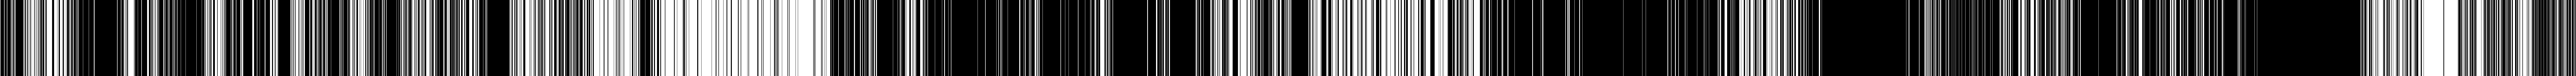

In [96]:
def col_to_RGB(col):
        """
        Converts a color string to an RGB color list using Colour library.
        params:
            col: a string representing the color required. (example: col="red")
        """
        color = [int(c*255) for c in Color(col).rgb]
        return color

#returns an image of a time bar with each time window belonging to a cluster
def draw_cluster_time_bar(n_comp, data, clusterer):
    
    size = 1
    # clusterer = GaussianMixture(n_components=n_comp, random_state=42).fit(data)
    pic = np.zeros(shape=(300, len(data)*size, 3))
    i = 0
    for v in data:
        j = clusterer.predict([v])
        pic[:,i:(i+1)*size, :] = col_to_RGB("black") if j == 0 else col_to_RGB("white") if j == 1 else col_to_RGB("gray")
        i+=1
    p = Image.fromarray(pic.astype('uint8'))
    return p

cluster_result_visual = draw_cluster_time_bar(2, reduced_data_50_ts_80, best_clus)
cluster_result_visual

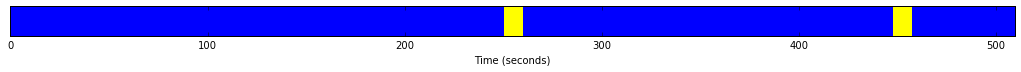

In [95]:
# returns an image of a time bar with each time window belonging to a cluster.
# this time bar is the true time bar given our knowledge of the data.
def draw_true_strip():
    indecies = frame_ts_50.index
    size = 1
    pic = np.zeros(shape=(300, len(reduced_data_50_ts_80)*size, 3))
    i = 0
    for k, v in zip(indecies, reduced_data_50_ts_80):
        if 447 <= k/1000. <= 457 or 250 <= k/1000. <= 260 or  250.9 <= k/1000. <= 252.4 or 252.5 <= k/1000. <= 253.8 \
            or 253.9 <= k/1000. <= 259:    
            pic[:,i*size:(i+1)*size, :] = col_to_RGB("yellow")
        else:
            pic[:,i*size:(i+1)*size, :] = col_to_RGB("blue")
        i+=1

    p = Image.fromarray(pic.astype('uint8'))
    return p

plt.figure(figsize=(18,7))
true_visual = draw_true_strip()
plt.imshow(pic, interpolation='nearest')
plt.axes().get_yaxis().set_visible(False)
plt.axes().set_xticklabels(['', 0, 100, 200, 300, 400, 500])
plt.xlabel("Time (seconds)")

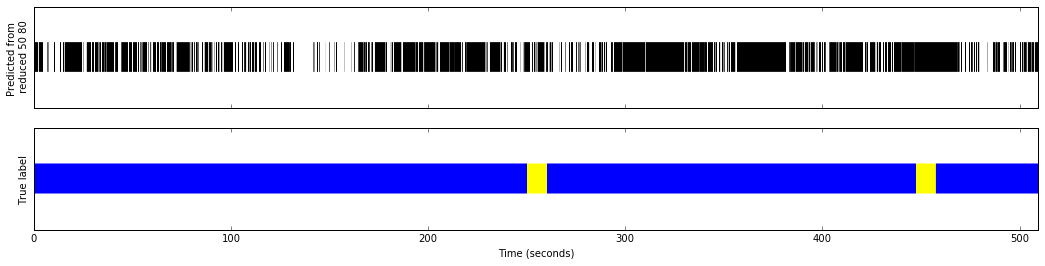

In [93]:
fig, (a,b) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(18,4))
#remove tick marks and only show label on y axis
b.set_ylabel("True label")
a.set_ylabel("Predicted from \n reduced 50 80")
b.axes.set_yticks([])
a.axes.set_xticklabels(['', 0, 100, 200, 300, 400, 500])
a.imshow(cluster_result_visual)
b.imshow(true_visual)
plt.xlabel("Time (seconds)")
fig.savefig("figures/strip_visual.pdf")